# Step1: DataCleaning and Preprocessing

In [ ]:
# from google.colab import files

# uploaded = files.upload()


Saving FSI-Firepoints-100625 Goa.csv to FSI-Firepoints-100625 Goa.csv
Saving GOA_AWS_IMD_data.csv to GOA_AWS_IMD_data (1).csv


## (i) Convert DMS to Decimal Degrees

In [ ]:
import pandas as pd

def dms_to_dd(dms_str):
    try:
        d, m, s = dms_str.replace('°', ' ').replace("'", ' ').replace('"', ' ').split()[:3]
        dd = float(d) + float(m)/60 + float(s)/3600
        return dd
    except:
        return None

# Load fire data
fire_df = pd.read_csv('/content/FSI-Firepoints-100625 Goa.csv', encoding='latin-1')
fire_df['Latitude_dd'] = fire_df['Latitude'].apply(dms_to_dd)
fire_df['Longitude_dd'] = fire_df['Longitude'].apply(dms_to_dd)
fire_df['Datetime'] = pd.to_datetime(fire_df['Fire Date'] + ' ' + fire_df['Fire Time'], errors='coerce')
fire_df.dropna(subset=['Datetime', 'Latitude_dd', 'Longitude_dd'], inplace=True)

fire_df.head()

,Fire Date,Fire Time,Source,Latitude,Longitude,State,District,Circle,Division,Range,Block/Section/Round,Beat,Forest Block,Compartment No,Unnamed: 14,Latitude_dd,Longitude_dd,Datetime
0,2021-11-11,02:07:15,SNPP,"15° 16' 41""N","74° 08' 52""E",GOA,SOUTH GOA,TERITORIAL CIRCLE,SOUTH GOA TERITORIAL DIVISION,SANGUEM RANGE,KIRLAPAL BLOCK,SANVORDEM BEAT,NaN,NaN,NaN,15.278056,74.147778,2021-11-11 02:07:15
1,2021-12-03,01:54:57,SNPP,"15° 16' 42""N","74° 08' 52""E",GOA,SOUTH GOA,TERITORIAL CIRCLE,SOUTH GOA TERITORIAL DIVISION,SANGUEM RANGE,KIRLAPAL BLOCK,SANVORDEM BEAT,NaN,NaN,NaN,15.278333,74.147778,2021-12-03 01:54:57
2,2021-12-17,02:32:19,SNPP,"15° 22' 22""N","74° 08' 28""E",GOA,SOUTH GOA,TERITORIAL CIRCLE,NORTH GOA TERITORIAL DIVISION,COLEM RANGE,DHARBANDORA BLOCK,TATODI 2 BEAT,NaN,NaN,NaN,15.372778,74.141111,2021-12-17 02:32:19
3,2021-12-18,02:13:23,SNPP,"15° 16' 38""N","74° 08' 58""E",GOA,SOUTH GOA,TERITORIAL CIRCLE,SOUTH GOA TERITORIAL DIVISION,SANGUEM RANGE,KIRLAPAL BLOCK,SANVORDEM BEAT,NaN,NaN,NaN,15.277222,74.149444,2021-12-18 02:13:23
4,2022-01-11,14:12:49,SNPP,"15° 44' 51""N","73° 52' 45""E",GOA,NORTH GOA,TERITORIAL CIRCLE,NORTH GOA TERITORIAL DIVISION,PERNEM RANGE,PERNEM BLOCK,CHANDEL BEAT,NaN,NaN,NaN,15.747500,73.879167,2022-01-11 14:12:49


# Step2: Spatial Join (shapeFile)

In [ ]:
# Upload shapefile (as .zip) and extract

In [ ]:
import zipfile
import geopandas as gpd
import pandas as pd

# Extract ZIP file
with zipfile.ZipFile("/content/shp.zip", 'r') as zip_ref:
    zip_ref.extractall("goa_shp")


# Load shapefile explicitly
gdf_boundary = gpd.read_file("goa_shp/shp/Protect_area.shp")



# Convert fire_df to GeoDataFrame
gdf_fire = gpd.GeoDataFrame(
    fire_df,
    geometry=gpd.points_from_xy(fire_df['Longitude_dd'], fire_df['Latitude_dd']),
    crs="EPSG:4326"
)

# Ensure CRS match
gdf_boundary = gdf_boundary.to_crs("EPSG:4326")

# Perform spatial join
joined = gpd.sjoin(gdf_fire, gdf_boundary, how="left", predicate='intersects')

# Display joined data
print(joined.head())


    Fire Date Fire Time Source      Latitude     Longitude State_left  \
0  2021-11-11  02:07:15   SNPP  15° 16' 41"N  74° 08' 52"E        GOA   
1  2021-12-03  01:54:57   SNPP  15° 16' 42"N  74° 08' 52"E        GOA   
2  2021-12-17  02:32:19   SNPP  15° 22' 22"N  74° 08' 28"E        GOA   
3  2021-12-18  02:13:23   SNPP  15° 16' 38"N  74° 08' 58"E        GOA   
4  2022-01-11  14:12:49   SNPP  15° 44' 51"N  73° 52' 45"E        GOA   

    District             Circle                       Division          Range  \
0  SOUTH GOA  TERITORIAL CIRCLE  SOUTH GOA TERITORIAL DIVISION  SANGUEM RANGE   
1  SOUTH GOA  TERITORIAL CIRCLE  SOUTH GOA TERITORIAL DIVISION  SANGUEM RANGE   
2  SOUTH GOA  TERITORIAL CIRCLE  NORTH GOA TERITORIAL DIVISION    COLEM RANGE   
3  SOUTH GOA  TERITORIAL CIRCLE  SOUTH GOA TERITORIAL DIVISION  SANGUEM RANGE   
4  NORTH GOA  TERITORIAL CIRCLE  NORTH GOA TERITORIAL DIVISION   PERNEM RANGE   

   ...            Datetime                   geometry  index_right  osm_id

In [ ]:
import os

# Check that the extraction directory exists
print("Contents of 'goa_shp':")
print(os.listdir('goa_shp'))


Contents of 'goa_shp':
['shp']


In [ ]:
print("Fire CRS:", gdf_fire.crs)
print("Boundary CRS:", gdf_boundary.crs)


Fire CRS: EPSG:4326
Boundary CRS: EPSG:4326


Let’s check if fire points fall inside any protected area polygons by plotting both:

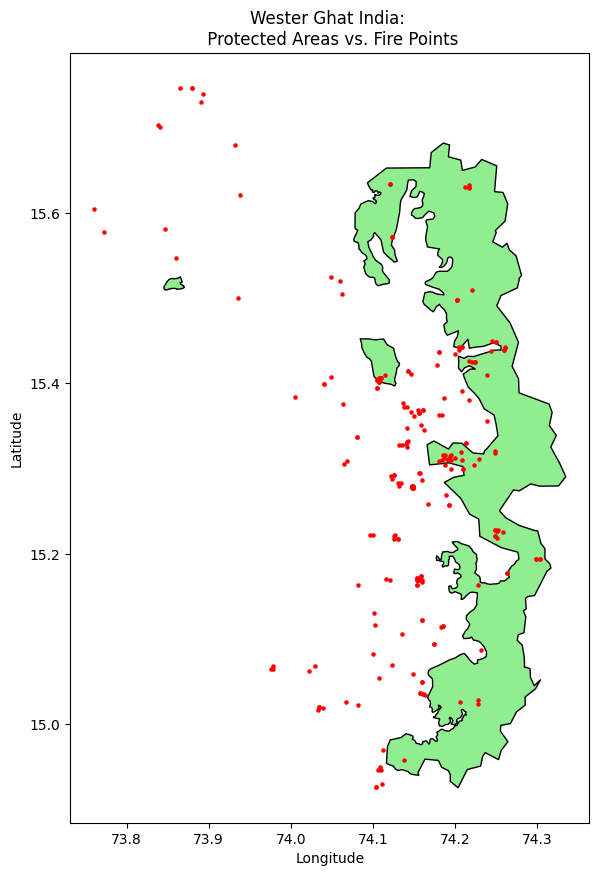

Number of protected areas: 1
Number of fire points: 237
Fire Points Bounds: [73.76       14.92638889 74.30333333 15.7475    ]
Protected Area Bounds: [73.8453445  14.924987   74.33509396 15.6824513 ]


In [ ]:
import matplotlib.pyplot as plt

# Plot boundary polygons
base = gdf_boundary.plot(color='lightgreen', edgecolor='black', figsize=(10, 10))

# Plot fire points
gdf_fire.plot(ax=base, color='red', markersize=5)

plt.title("Wester Ghat India: \n Protected Areas vs. Fire Points")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

print(f"Number of protected areas: {len(gdf_boundary)}")
print(f"Number of fire points: {len(gdf_fire)}")

print("Fire Points Bounds:", gdf_fire.total_bounds)
print("Protected Area Bounds:", gdf_boundary.total_bounds)


## (i) Plot - FirePoint lies inside AOI

Visually verify how many fire points fall inside the green area

Try a spatial join again and filter only the matched rows:

In [ ]:
joined_inside = joined[joined['index_right'].notnull()]

print(f"Number of fire points inside protected area: {len(joined_inside)}")


Number of fire points inside protected area: 65


Conclusion till this step:

* We had 237 fire points, out of which 65 fall within the protected area polygon.

* The NaNs in the spatial join result simply mean those fire points fell outside the protected boundary.

* Our spatial analysis is correctly set up.



## (ii) Total no of FP

In [ ]:
# Export the 65 inside points to CSV (attributes only):

joined_inside = joined[joined['index_right'].notnull()]
joined_inside.to_csv("Goa fire_points_inside_protected_area.csv", index=False)


In [ ]:
# Export to GeoJSON (preserves geometry):

joined_inside.to_file("Goa fire_points_inside_protected_area.geojson", driver="GeoJSON")

## (iii) plot FP with DMS (degree-minute-second)

    Fire Date Fire Time Source      Latitude     Longitude State_left  \
0  2021-11-11  02:07:15   SNPP  15° 16' 41"N  74° 08' 52"E        GOA   
1  2021-12-03  01:54:57   SNPP  15° 16' 42"N  74° 08' 52"E        GOA   
2  2021-12-17  02:32:19   SNPP  15° 22' 22"N  74° 08' 28"E        GOA   
3  2021-12-18  02:13:23   SNPP  15° 16' 38"N  74° 08' 58"E        GOA   
4  2022-01-11  14:12:49   SNPP  15° 44' 51"N  73° 52' 45"E        GOA   

    District             Circle                       Division          Range  \
0  SOUTH GOA  TERITORIAL CIRCLE  SOUTH GOA TERITORIAL DIVISION  SANGUEM RANGE   
1  SOUTH GOA  TERITORIAL CIRCLE  SOUTH GOA TERITORIAL DIVISION  SANGUEM RANGE   
2  SOUTH GOA  TERITORIAL CIRCLE  NORTH GOA TERITORIAL DIVISION    COLEM RANGE   
3  SOUTH GOA  TERITORIAL CIRCLE  SOUTH GOA TERITORIAL DIVISION  SANGUEM RANGE   
4  NORTH GOA  TERITORIAL CIRCLE  NORTH GOA TERITORIAL DIVISION   PERNEM RANGE   

   ...            Datetime                   geometry  index_right  osm_id

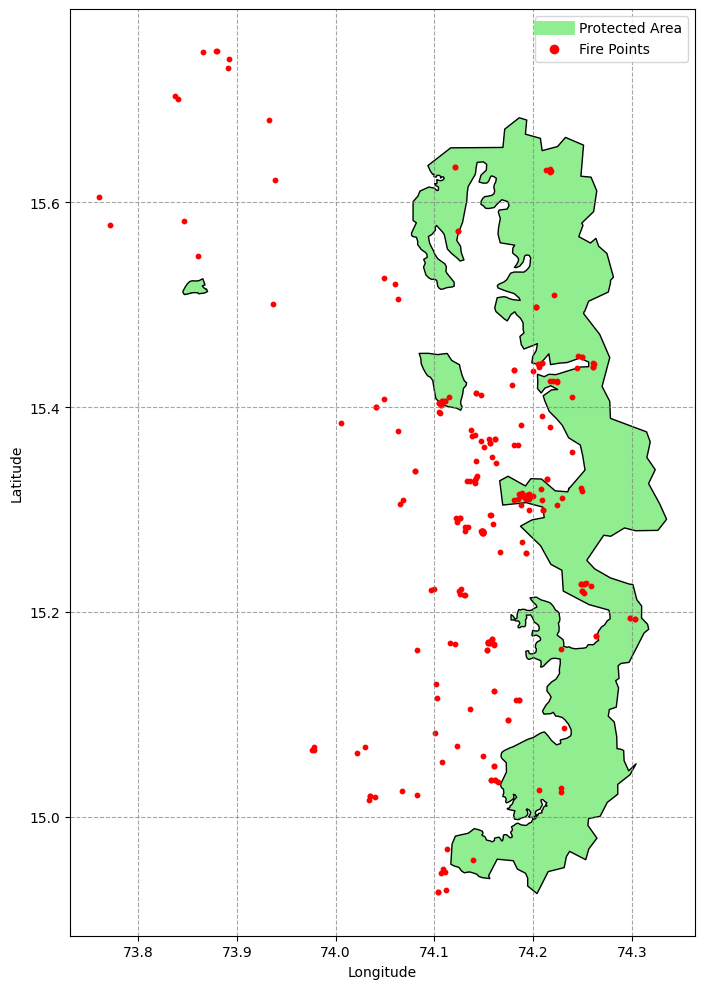

In [ ]:
import zipfile
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from matplotlib.lines import Line2D

# ----------------------------
# 1. Extract and Load Shapefile
# ----------------------------
with zipfile.ZipFile("/content/shp.zip", 'r') as zip_ref:
    zip_ref.extractall("goa_shp")

# Load boundary shapefile (find .shp file path inside extracted folder)
gdf_boundary = gpd.read_file("goa_shp/shp/Protect_area.shp")  # Replace with actual .shp filename

# ----------------------------
# 2. Load and Process Fire Data
# ----------------------------
def dms_to_dd(dms_str):
    try:
        d, m, s = dms_str.replace('°', ' ').replace("'", ' ').replace('"', ' ').split()[:3]
        dd = float(d) + float(m)/60 + float(s)/3600
        return dd
    except:
        return None



fire_df = pd.read_csv('/content/FSI-Firepoints-100625 Goa.csv', encoding='latin-1')
fire_df['Latitude_dd'] = fire_df['Latitude'].apply(dms_to_dd)
fire_df['Longitude_dd'] = fire_df['Longitude'].apply(dms_to_dd)
fire_df['Datetime'] = pd.to_datetime(fire_df['Fire Date'] + ' ' + fire_df['Fire Time'], errors='coerce')
fire_df.dropna(subset=['Datetime', 'Latitude_dd', 'Longitude_dd'], inplace=True)

# Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(fire_df['Longitude_dd'], fire_df['Latitude_dd'])]
gdf_fire = gpd.GeoDataFrame(fire_df, geometry=geometry, crs="EPSG:4326")

# ----------------------------
# 3. Reproject and Join
# ----------------------------
gdf_boundary = gdf_boundary.to_crs("EPSG:4326")
joined = gpd.sjoin(gdf_fire, gdf_boundary, how="left", predicate='intersects')
print(joined.head())

# ----------------------------
# 4. Plot with Lat/Lon Grid
# ----------------------------
fig, ax = plt.subplots(figsize=(10, 10))

# Plot protected area
gdf_boundary.plot(ax=ax, color='lightgreen', edgecolor='black', label='Protected Area')

# Plot fire points
gdf_fire.plot(ax=ax, color='red', markersize=10, label='Fire Points')

# Add labels and grid
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True, linestyle='--', color='gray', alpha=0.7)

# Add legend
custom_lines = [
    Line2D([0], [0], color='lightgreen', lw=10, label='Protected Area'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Fire Points')
]
ax.legend(handles=custom_lines)

plt.tight_layout()
plt.show()


## (iv) FP only

     Fire Date Fire Time Source      Latitude     Longitude State_left  \
6   2022-01-29  02:25:12   SNPP  15° 11' 36"N  74° 18' 12"E        GOA   
7   2022-01-29  02:25:12   SNPP  15° 11' 36"N  74° 18' 12"E        GOA   
8   2022-01-29  02:25:12   SNPP  15° 11' 39"N  74° 17' 54"E        GOA   
9   2022-01-29  02:25:12   SNPP  15° 11' 39"N  74° 17' 54"E        GOA   
29  2023-01-01  02:07:36   SNPP  15° 29' 51"N  74° 12' 09"E        GOA   

     District             Circle                       Division  \
6   SOUTH GOA    WILDLIFE CIRCLE    SOUTH GOA WILDLIFE DIVISION   
7   SOUTH GOA    WILDLIFE CIRCLE    SOUTH GOA WILDLIFE DIVISION   
8   SOUTH GOA    WILDLIFE CIRCLE    SOUTH GOA WILDLIFE DIVISION   
9   SOUTH GOA    WILDLIFE CIRCLE    SOUTH GOA WILDLIFE DIVISION   
29  NORTH GOA  TERITORIAL CIRCLE  NORTH GOA TERITORIAL DIVISION   

                  Range  ...            Datetime                   geometry  \
6   NETRAVALI WLS RANGE  ... 2022-01-29 02:25:12  POINT (74.30333 15.1933

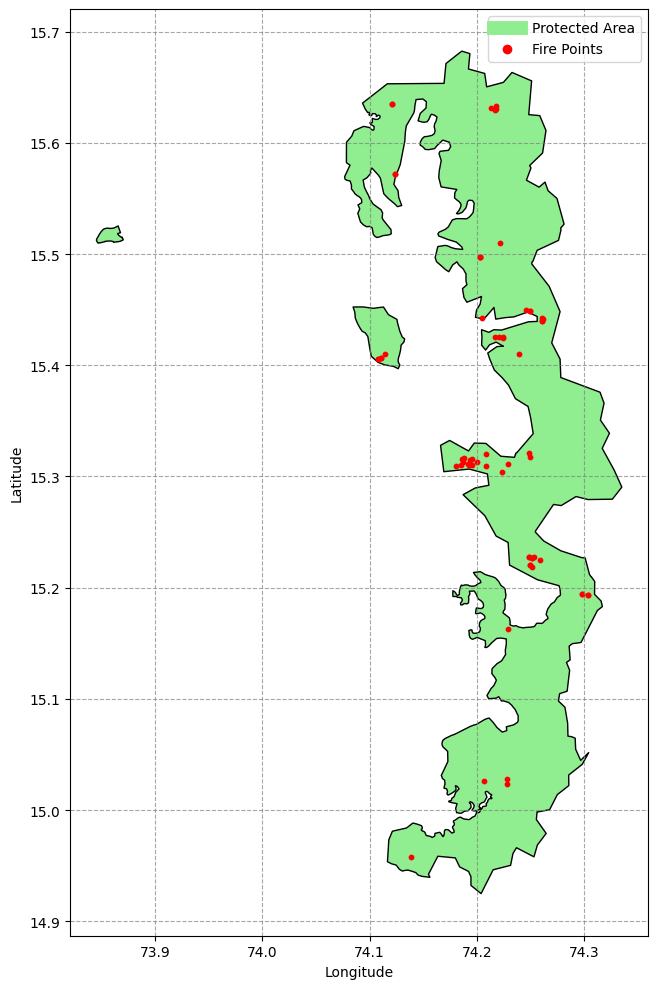

In [ ]:
# ----------------------------
# 3. Reproject and Join
# ----------------------------
gdf_boundary = gdf_boundary.to_crs("EPSG:4326")
joined = gpd.sjoin(gdf_fire, gdf_boundary, how="inner", predicate='intersects')

print(joined.head())
print(f"Total fire points inside boundary: {len(joined)}")

# ----------------------------
# 4. Plot with Lat/Lon Grid
# ----------------------------
fig, ax = plt.subplots(figsize=(10, 10))

# Plot protected area
gdf_boundary.plot(ax=ax, color='lightgreen', edgecolor='black', label='Protected Area')

# Plot only fire points inside boundary
joined.plot(ax=ax, color='red', markersize=10, label='Fire Points (Inside)')

# Add labels and grid
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True, linestyle='--', color='gray', alpha=0.7)

# Add legend
custom_lines = [
    Line2D([0], [0], color='lightgreen', lw=10, label='Protected Area'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Fire Points')
]
ax.legend(handles=custom_lines)

plt.tight_layout()
plt.show()


# Step3: Feature Engineering

## (i) CleanWeatherData - IMD

In [ ]:
# Step 1: Import libraries
import pandas as pd
import numpy as np

# Step 2: Load CSV file
df = pd.read_csv("D:\BITS_Pillani\CleanData_GOA_IMD\GOA_AWS_IMD_data.csv")

# Step 3: View basic info
print(df.shape)
df.head()

# Step 4: Clean column names
df.columns = (
    df.columns.str.strip()
              .str.replace(r"[^\w\s]", "", regex=True)
              .str.replace(" ", "_")
)

# Step 5: Combine DATE + TIME into a single DATETIME column
df['DATETIME'] = pd.to_datetime(
    df['DATEDDMMYYYY'] + ' ' + df['TIME_UTC'],
    dayfirst=True,
    errors='coerce'
)

# Step 6: Replace placeholders like 'L', '', '-', 'NA' with NaN
df.replace(['', 'L', '-', 'NA', 'NaN'], np.nan, inplace=True)

# Step 7: Convert numeric columns where possible
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='ignore')

# Step 8: Check missing values
print("\nMissing values per column:")
print(df.isna().sum())

# Step 9: Fill numeric NaNs with column mean
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Step 10: Drop rows with too many NaNs (optional)
df.dropna(thresh=len(df.columns) // 2, inplace=True)

# Step 11: Save cleaned CSV
df.to_csv("GOA_AWS_IMD_data_cleaned.csv", index=False)

print("\nData cleaning complete. Cleaned file saved as 'GOA_AWS_IMD_data_cleaned.csv'")


In [ ]:
missing_percent = (df.isna().sum() / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': df.isna().sum(),
                           'Missing %': missing_percent})
missing_df.sort_values('Missing %', ascending=False)

In [ ]:
# Drop columns with more than 50% missing data
threshold = 0.5
cols_to_drop = missing_df[missing_df['Missing %'] > (threshold * 100)].index
df.drop(columns=cols_to_drop, inplace=True)

print(f"Dropped columns: {list(cols_to_drop)}")


In [ ]:
# Convert to readable datetime format
df['DATETIME'] = pd.to_datetime(
    df['DATEDDMMYYYY'] + ' ' + df['TIME_UTC'],
    dayfirst=True,
    errors='coerce'
)

# Format as normal string before saving
df['DATETIME'] = df['DATETIME'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Save cleaned CSV
df.to_csv("removeMissingValueGoa_ReadableForm.csv", index=False)


## (ii) Match AWS to FF data

Match/merge fire point data with the nearest weather data on Date + Time.

Spatially, fire point location can be enriched with AWS station weather (nearest AWS station → join based on distance OR assign based on region).

In [ ]:
# Install geopandas if not available
!pip install geopandas shapely pyproj --quiet

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# -----------------------------
# 1. Load Datasets
# -----------------------------
aws_path = "/content/removeMissingValueGoa_ReadableForm.csv"
fire_path = "/content/FSI-Firepoints-100625 Goa.csv"

# Read CSV files
aws_df = pd.read_csv(aws_path)
fire_df = pd.read_csv(fire_path, encoding='latin-1') # Specify the encoding

print("AWS Dataset shape:", aws_df.shape)
print("Fire Dataset shape:", fire_df.shape)

# -----------------------------
# 2. Convert Date + Time columns and DMS to Decimal Degrees for Fire Data
# -----------------------------
# Assuming AWS has 'DATEDDMMYYYY' + 'TIME_UTC' columns based on previous cleaning steps
aws_df['Datetime'] = pd.to_datetime(aws_df['DATEDDMMYYYY'] + " " + aws_df['TIME_UTC'], dayfirst=True, errors='coerce')

# Assuming Fire dataset has 'Fire Date' + 'Fire Time' columns
fire_df['Datetime'] = pd.to_datetime(fire_df['Fire Date'] + " " + fire_df['Fire Time'], errors='coerce')

# Convert DMS to Decimal Degrees for Fire Data
def dms_to_dd(dms_str):
    try:
        d, m, s = dms_str.replace('°', ' ').replace("'", ' ').replace('"', ' ').split()[:3]
        dd = float(d) + float(m)/60 + float(s)/3600
        return dd
    except:
        return None

fire_df['Latitude_dd'] = fire_df['Latitude'].apply(dms_to_dd)
fire_df['Longitude_dd'] = fire_df['Longitude'].apply(dms_to_dd)
fire_df.dropna(subset=['Datetime', 'Latitude_dd', 'Longitude_dd'], inplace=True)


# -----------------------------
# 3. Merge datasets on DateTime
# -----------------------------
merged_df = pd.merge_asof(
    fire_df.sort_values("Datetime"),
    aws_df.sort_values("Datetime"),
    on="Datetime",
    direction="nearest",   # take nearest time if not exact match
    tolerance=pd.Timedelta("1H")  # allow 1 hour tolerance
)

print("Merged Dataset shape:", merged_df.shape)

# -----------------------------
# 4. Convert Fire Points to GeoDataFrame (optional spatial handling)
# -----------------------------
# Assuming Fire dataset has 'Latitude_dd' and 'Longitude_dd' columns from previous conversion
geometry = [Point(xy) for xy in zip(merged_df["Longitude_dd"], merged_df["Latitude_dd"])]
gdf_fire = gpd.GeoDataFrame(merged_df, geometry=geometry, crs="EPSG:4326")

print(gdf_fire.head())

# -----------------------------
# 5. Save Final Overlapped Data
# -----------------------------
output_path = "/content/Overlapped_IMD_Fire.csv"
gdf_fire.to_csv(output_path, index=False)
print("✅ Final Overlapped Dataset saved to:", output_path)

AWS Dataset shape: (589451, 31)
Fire Dataset shape: (237, 15)
Merged Dataset shape: (237, 49)
    Fire Date Fire Time Source      Latitude     Longitude State   District  \
0  2021-11-11  02:07:15   SNPP  15° 16' 41"N  74° 08' 52"E   GOA  SOUTH GOA   
1  2021-12-03  01:54:57   SNPP  15° 16' 42"N  74° 08' 52"E   GOA  SOUTH GOA   
2  2021-12-17  02:32:19   SNPP  15° 22' 22"N  74° 08' 28"E   GOA  SOUTH GOA   
3  2021-12-18  02:13:23   SNPP  15° 16' 38"N  74° 08' 58"E   GOA  SOUTH GOA   
4  2022-01-11  14:12:49   SNPP  15° 44' 51"N  73° 52' 45"E   GOA  NORTH GOA   

              Circle                       Division          Range  ...  \
0  TERITORIAL CIRCLE  SOUTH GOA TERITORIAL DIVISION  SANGUEM RANGE  ...   
1  TERITORIAL CIRCLE  SOUTH GOA TERITORIAL DIVISION  SANGUEM RANGE  ...   
2  TERITORIAL CIRCLE  NORTH GOA TERITORIAL DIVISION    COLEM RANGE  ...   
3  TERITORIAL CIRCLE  SOUTH GOA TERITORIAL DIVISION  SANGUEM RANGE  ...   
4  TERITORIAL CIRCLE  NORTH GOA TERITORIAL DIVISION   PE

/tmp/ipython-input-3219430172.py:52: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  tolerance=pd.Timedelta("1H")  # allow 1 hour tolerance


In [ ]:
# Exploratory Data Analysis (EDA) to check how many fire events successfully matched AWS data (rows count).

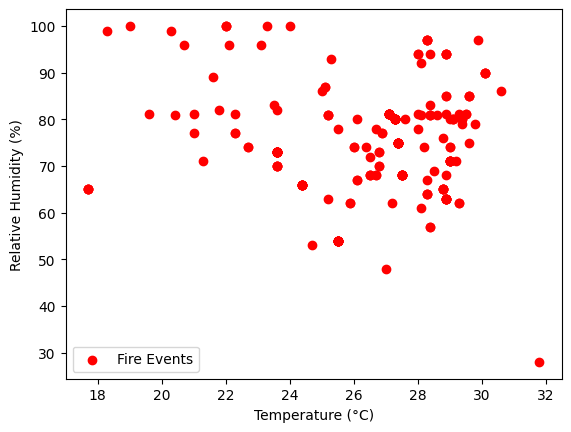

In [ ]:
import matplotlib.pyplot as plt

gdf_fire['Fire_Occurred'] = 1  # since these are actual fire points
plt.scatter(gdf_fire['TEMP_C'], gdf_fire['RH_'], c='red', label="Fire Events")
plt.xlabel("Temperature (°C)")
plt.ylabel("Relative Humidity (%)")
plt.legend()
plt.show()


In [ ]:
# Q. How Many Fire Points Matched AWS Data?


matched_count = gdf_fire.shape[0]
print(f"✅ Total Fire Events Matched with AWS Data: {matched_count}")


✅ Total Fire Events Matched with AWS Data: 237


In [ ]:
# If you had an original count of fire points before merging:

# original_fire_count = fire_df.shape[0]
# print(f"Original Fire Points Count: {original_fire_count}")

total_fire_points = fire_df.shape[0]
print(f"🔢 Matching Rate: {matched_count} / {total_fire_points} ({matched_count / total_fire_points:.2%})")


🔢 Matching Rate: 237 / 237 (100.00%)


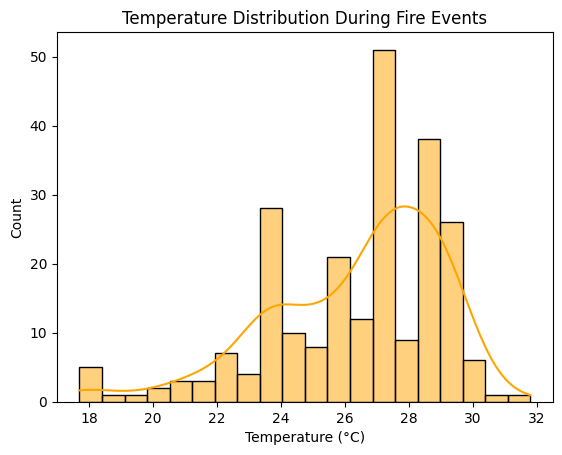

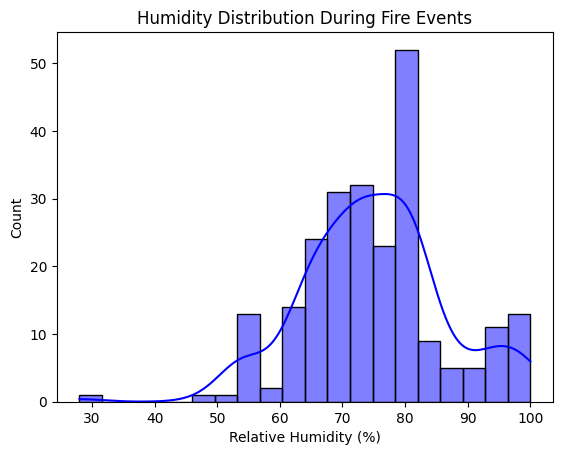

In [ ]:
import seaborn as sns

sns.histplot(gdf_fire['TEMP_C'], bins=20, kde=True, color='orange')
plt.title("Temperature Distribution During Fire Events")
plt.xlabel("Temperature (°C)")
plt.show()

sns.histplot(gdf_fire['RH_'], bins=20, kde=True, color='blue')
plt.title("Humidity Distribution During Fire Events")
plt.xlabel("Relative Humidity (%)")
plt.show()


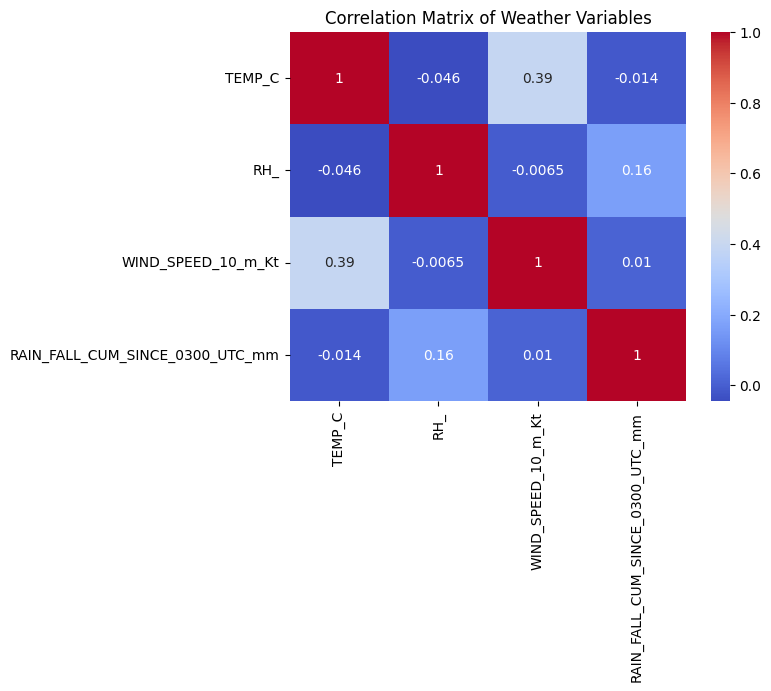

In [ ]:
# correlation matrix: Check which variables influence fire conditions most


numeric_cols = ['TEMP_C', 'RH_', 'WIND_SPEED_10_m_Kt', 'RAIN_FALL_CUM_SINCE_0300_UTC_mm']  # adjust columns if needed
corr = gdf_fire[numeric_cols].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Weather Variables")
plt.show()


/tmp/ipython-input-3184125208.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Hour', data=gdf_fire, palette='Reds')


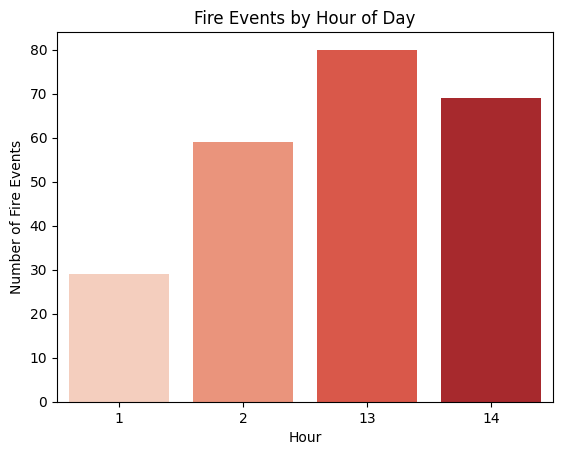

In [ ]:
# Time-Based Analysis: Check at what times most fires occur

gdf_fire['Hour'] = gdf_fire['Datetime'].dt.hour
sns.countplot(x='Hour', data=gdf_fire, palette='Reds')
plt.title("Fire Events by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of Fire Events")
plt.show()




In [ ]:
# we can alos draw the confusion matrix if we will done your predicaton step

## (iii) FinalOverlap data with shpGoa

In [ ]:
# ALL AWS location.csv and also save Nearest AWS device with type in final dataset



In [ ]:
# ========================================
# Step 0: Import Libraries
# ========================================
# Import necessary libraries for data handling and geospatial distance calculation
import pandas as pd
from geopy.distance import geodesic

# ========================================
# Step 1: Load Input Data
# ========================================
# Load the merged fire-weather dataset (already matched on datetime)
fire_data_path = "/content/Overlapped_IMD_Fire.csv"
fire_df = pd.read_csv(fire_data_path)

# Load the AWS station location metadata (list of all station coordinates and types)
aws_station_path = "/content/All AWS Location.csv"  # 🔁 Replace with correct path if needed
station_df = pd.read_csv(aws_station_path)

# ========================================
# Step 2: Prepare Coordinates for Distance Calculation
# ========================================
# Create (lat, lon) tuples for each fire point and each AWS station
# This prepares the data for geodesic (earth surface) distance measurement
fire_points = list(zip(fire_df["Latitude_dd"], fire_df["Longitude_dd"]))
station_points = list(zip(station_df["LATITUDE"], station_df["LONGITUDE"]))

# ========================================
# Step 3: Find Nearest AWS Station for Each Fire Point
# ========================================
# For every fire event, find the nearest AWS device based on geographic distance
# We also store the station name, its type (e.g., AWS, ARG, AGRO), and the actual distance in km

nearest_station_names = []
nearest_station_types = []
nearest_distances_km = []

for fire_pt in fire_points:
    distances = [geodesic(fire_pt, station_pt).km for station_pt in station_points]
    min_index = distances.index(min(distances))

    nearest_station_names.append(station_df.iloc[min_index]["STATION"])
    nearest_station_types.append(station_df.iloc[min_index]["TYPE"])
    nearest_distances_km.append(distances[min_index])

# ========================================
# Step 4: Add Nearest Station Info to Dataset
# ========================================
# Append new columns to the fire dataset:
# - Name of the nearest AWS station
# - Station type (AWS / ARG / AGRO etc.)
# - Distance in kilometers from the fire event
fire_df["Nearest_Station"] = nearest_station_names
fire_df["Nearest_Station_Type"] = nearest_station_types
fire_df["Distance_to_Station_km"] = nearest_distances_km

# ========================================
# Step 5: Save Final Output Dataset
# ========================================
# Final CSV now contains both fire-weather data AND nearest AWS device info
# Useful for machine learning, EDA, and geospatial insights
final_path = "/content/Goa_Fire_Weather_AWS_Nearest.csv"
fire_df.to_csv(final_path, index=False)

print("✅ Also saved Nearest AWS device with type in final dataset")
print("📂 Final dataset saved to:", final_path)


✅ Also saved Nearest AWS device with type in final dataset
📂 Final dataset saved to: /content/Goa_Fire_Weather_AWS_Nearest.csv


## (iv) EDA

EDA checks (like histogram of distances, count of AWS types used, etc.) before model training? That helps in checking if our matching step is meaningful

✅ Dataset Loaded Successfully
Shape of dataset: (237, 53)

🔎 First 5 rows:
    Fire Date Fire Time Source      Latitude     Longitude State   District  \
0  2021-11-11  02:07:15   SNPP  15° 16' 41"N  74° 08' 52"E   GOA  SOUTH GOA   
1  2021-12-03  01:54:57   SNPP  15° 16' 42"N  74° 08' 52"E   GOA  SOUTH GOA   
2  2021-12-17  02:32:19   SNPP  15° 22' 22"N  74° 08' 28"E   GOA  SOUTH GOA   
3  2021-12-18  02:13:23   SNPP  15° 16' 38"N  74° 08' 58"E   GOA  SOUTH GOA   
4  2022-01-11  14:12:49   SNPP  15° 44' 51"N  73° 52' 45"E   GOA  NORTH GOA   

              Circle                       Division          Range  ...  \
0  TERITORIAL CIRCLE  SOUTH GOA TERITORIAL DIVISION  SANGUEM RANGE  ...   
1  TERITORIAL CIRCLE  SOUTH GOA TERITORIAL DIVISION  SANGUEM RANGE  ...   
2  TERITORIAL CIRCLE  NORTH GOA TERITORIAL DIVISION    COLEM RANGE  ...   
3  TERITORIAL CIRCLE  SOUTH GOA TERITORIAL DIVISION  SANGUEM RANGE  ...   
4  TERITORIAL CIRCLE  NORTH GOA TERITORIAL DIVISION   PERNEM RANGE  ...   


<Figure size 1500x800 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


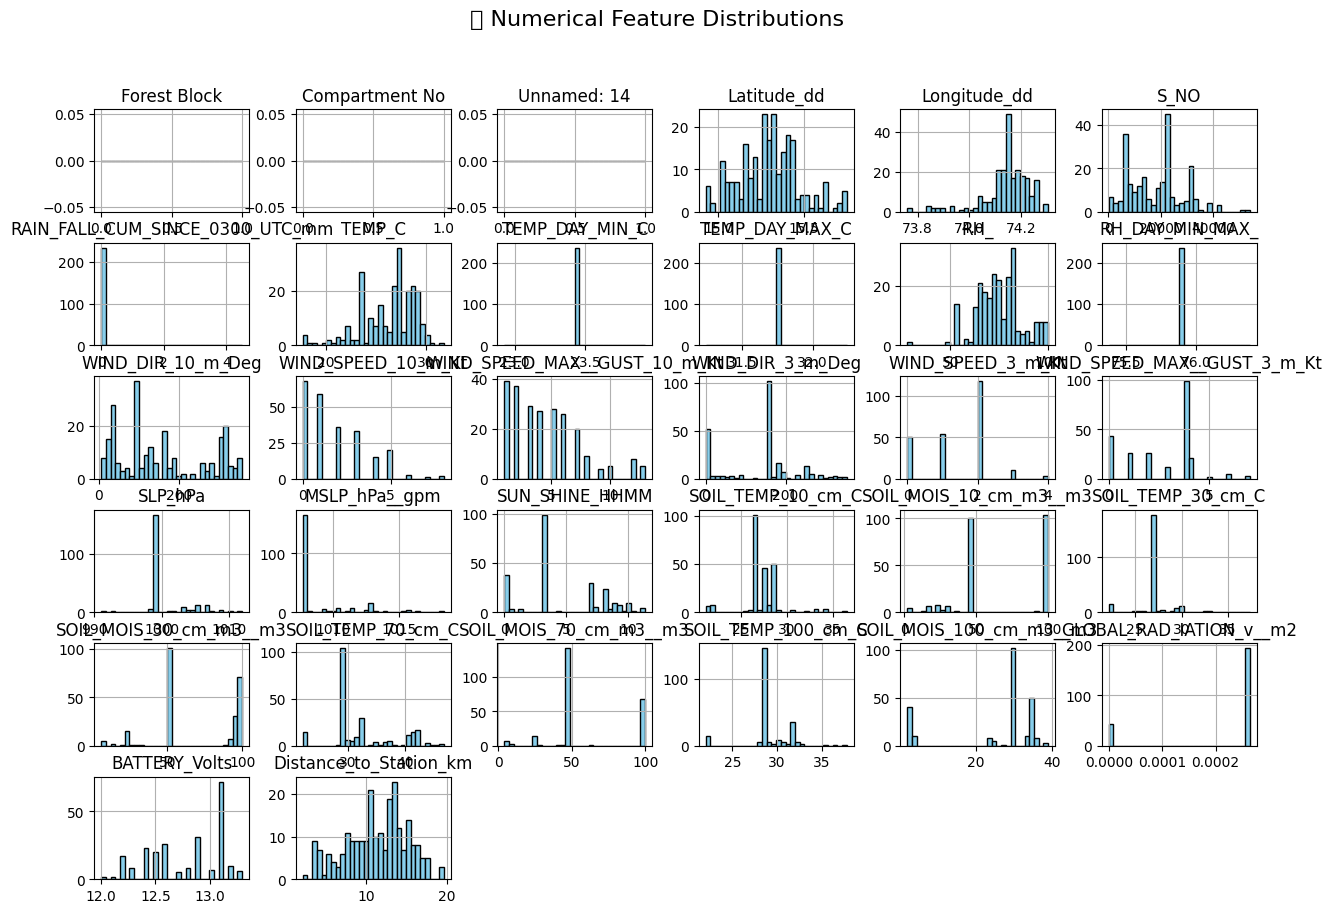

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


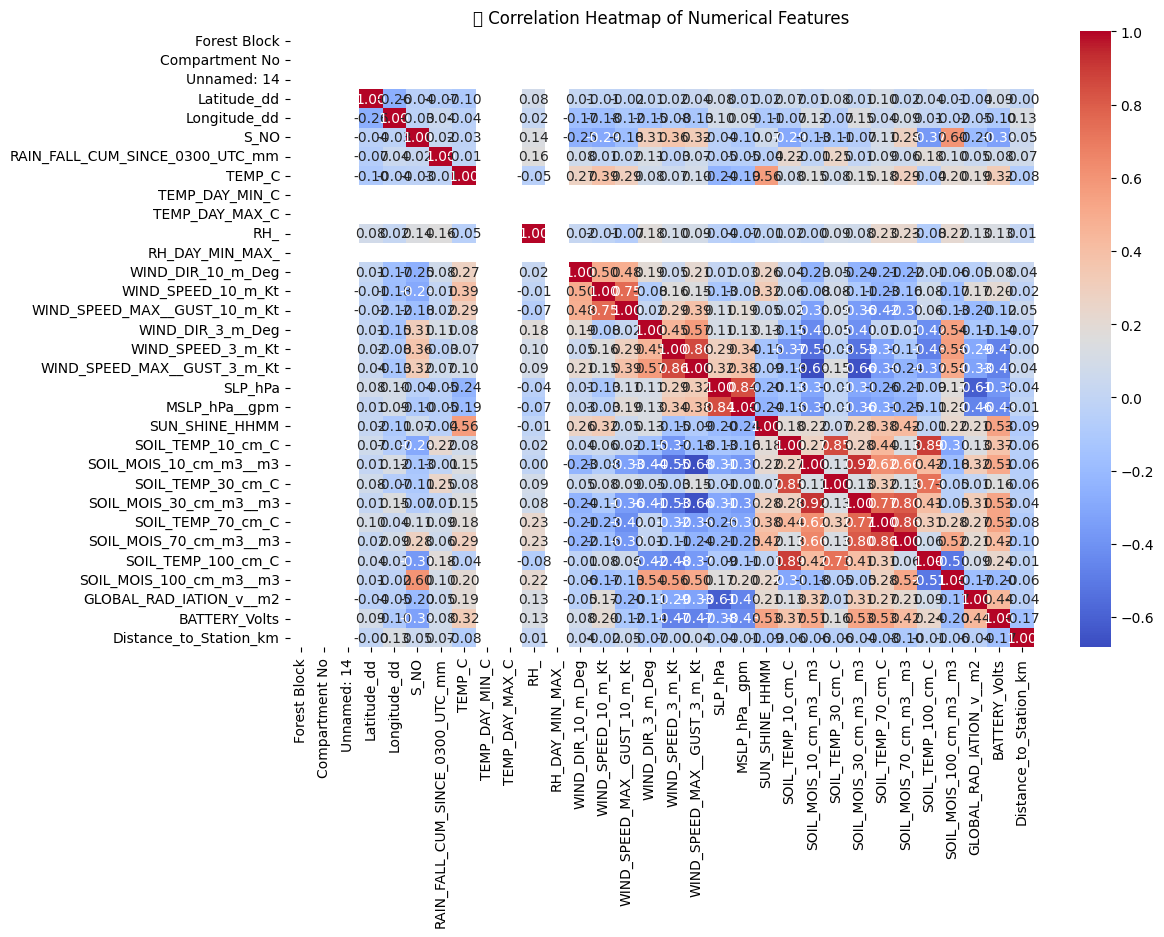

/tmp/ipython-input-2000402519.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="viridis")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


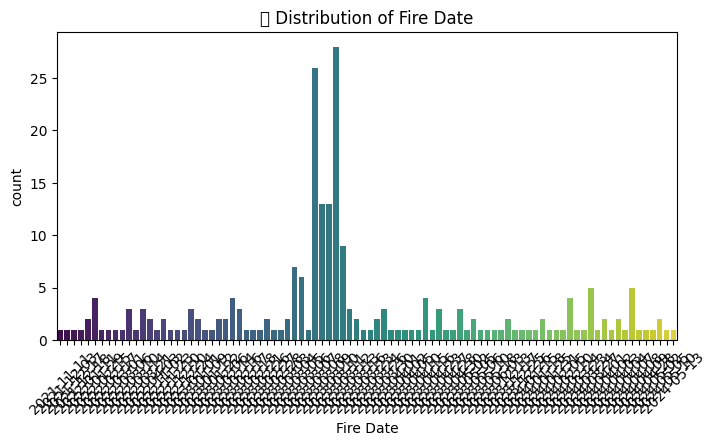

/tmp/ipython-input-2000402519.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="viridis")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


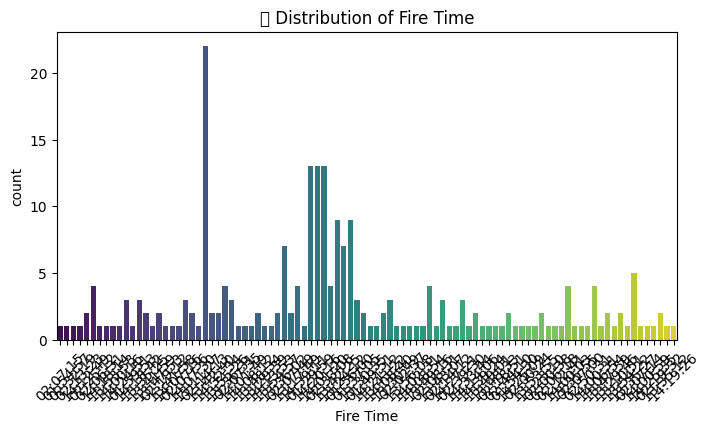

/tmp/ipython-input-2000402519.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="viridis")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


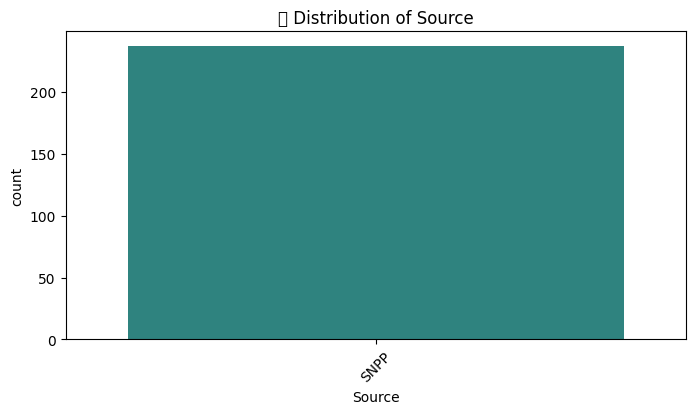

/tmp/ipython-input-2000402519.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="viridis")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


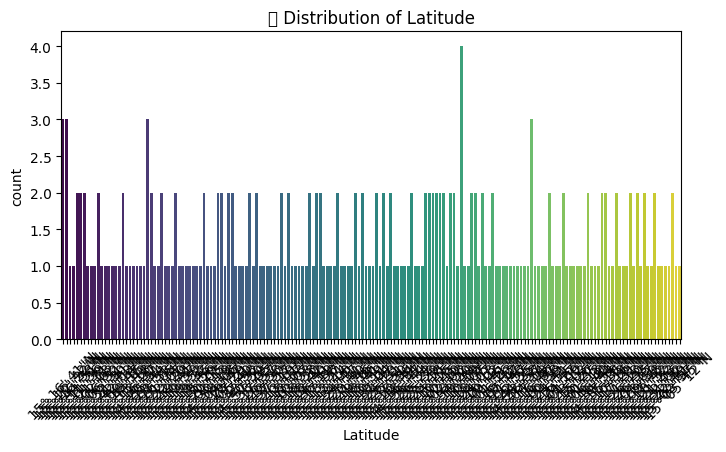

/tmp/ipython-input-2000402519.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="viridis")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


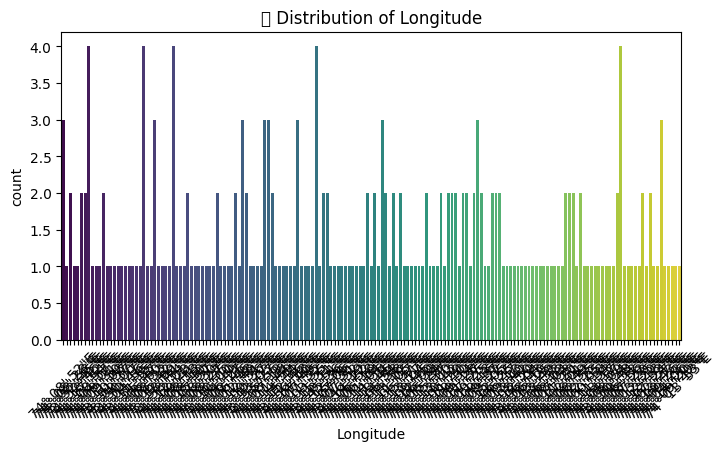

/tmp/ipython-input-2000402519.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="viridis")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


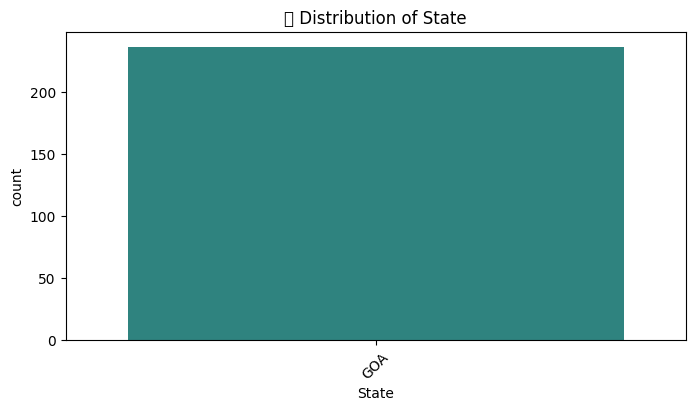

/tmp/ipython-input-2000402519.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="viridis")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


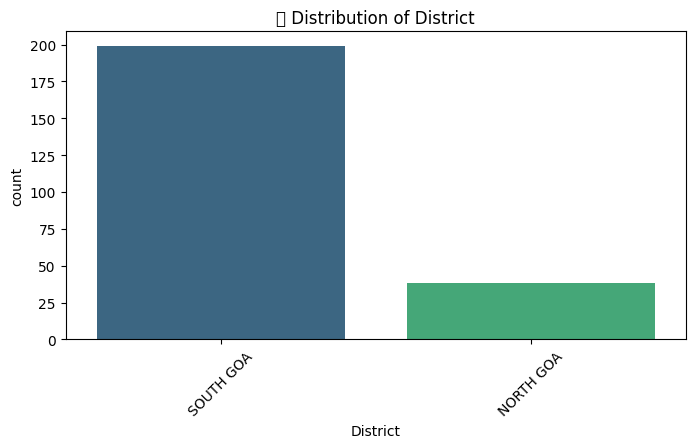

/tmp/ipython-input-2000402519.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="viridis")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


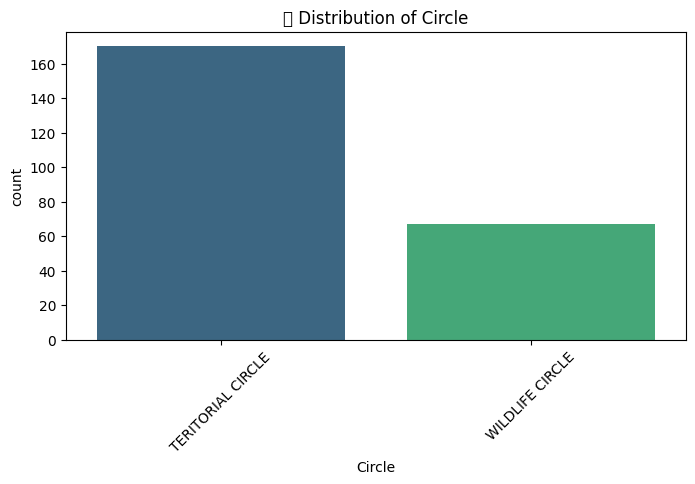

/tmp/ipython-input-2000402519.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="viridis")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


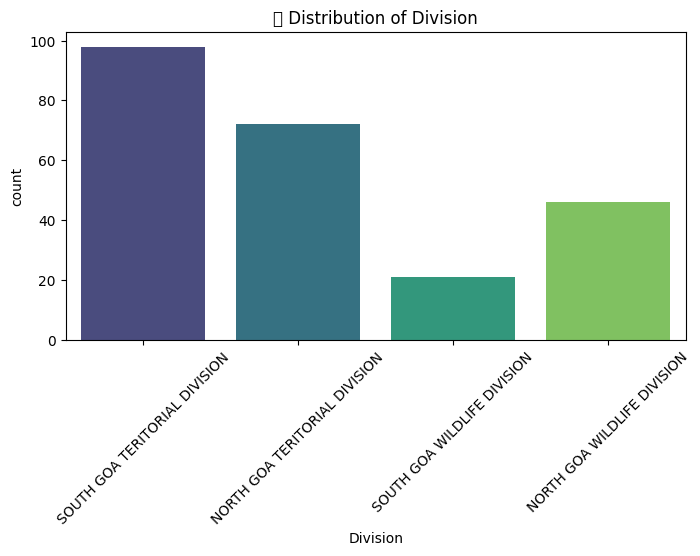

/tmp/ipython-input-2000402519.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="viridis")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


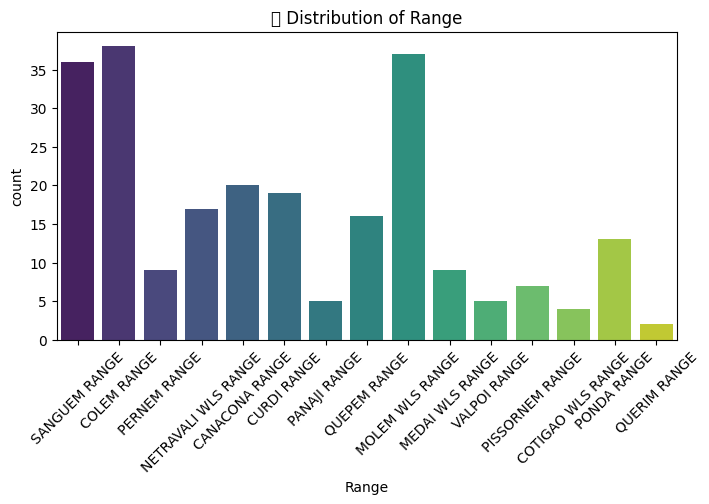

/tmp/ipython-input-2000402519.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="viridis")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


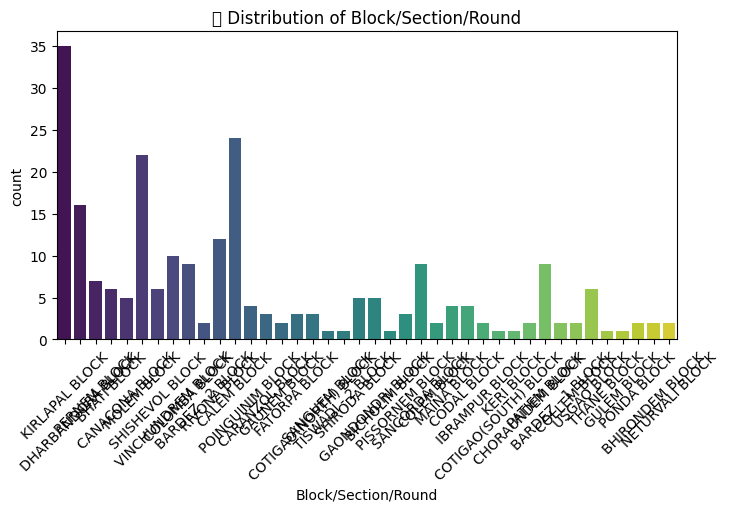

/tmp/ipython-input-2000402519.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="viridis")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


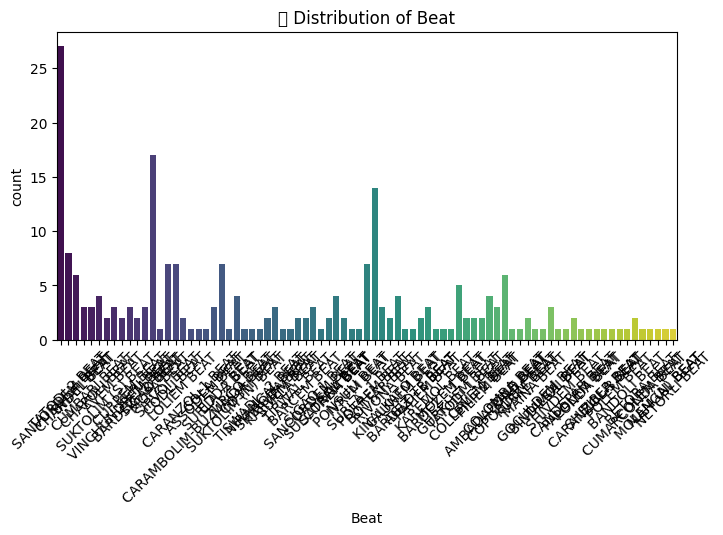

/tmp/ipython-input-2000402519.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="viridis")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


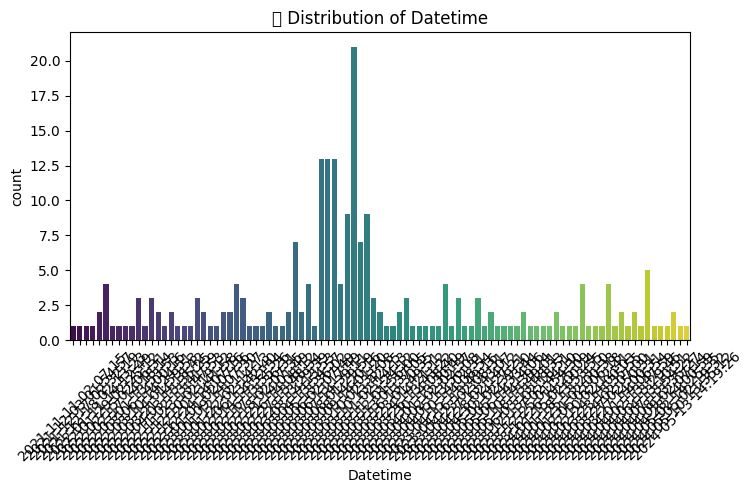

/tmp/ipython-input-2000402519.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="viridis")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


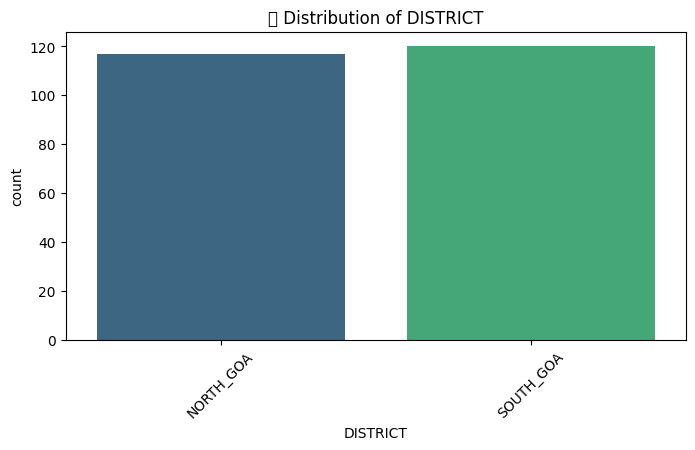

/tmp/ipython-input-2000402519.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="viridis")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


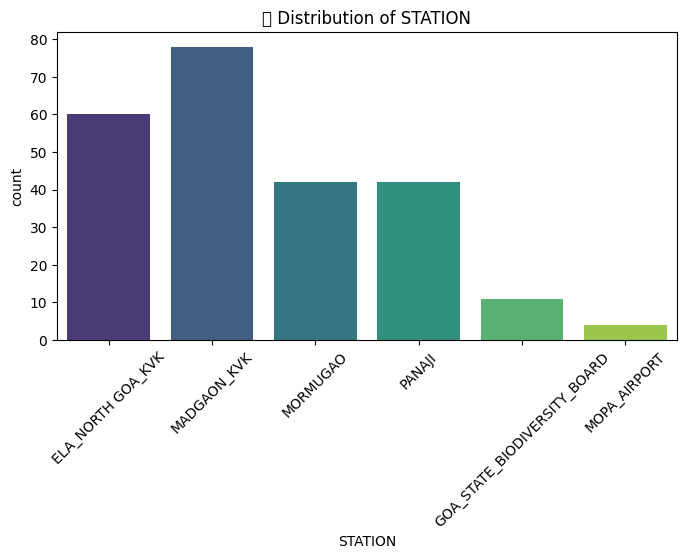

/tmp/ipython-input-2000402519.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="viridis")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


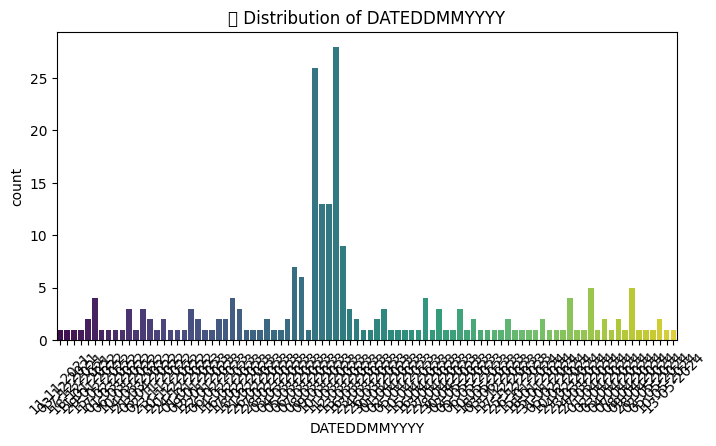

/tmp/ipython-input-2000402519.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="viridis")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


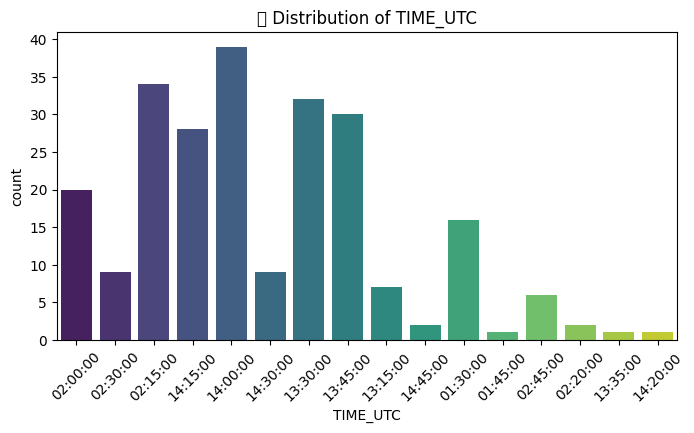

/tmp/ipython-input-2000402519.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="viridis")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


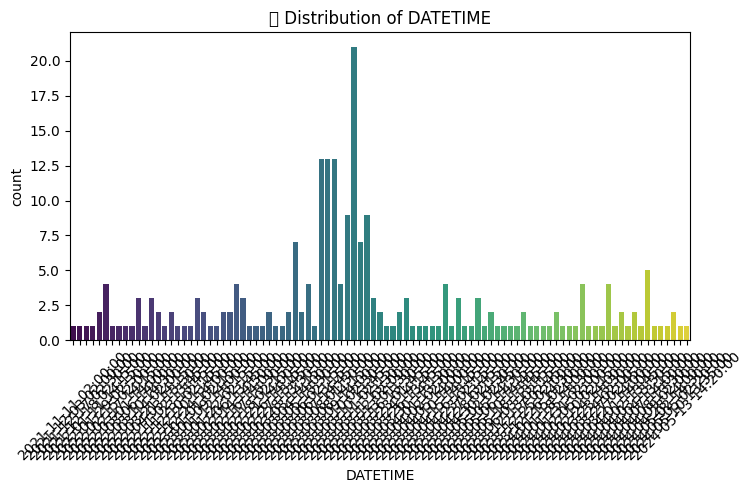

/tmp/ipython-input-2000402519.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="viridis")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


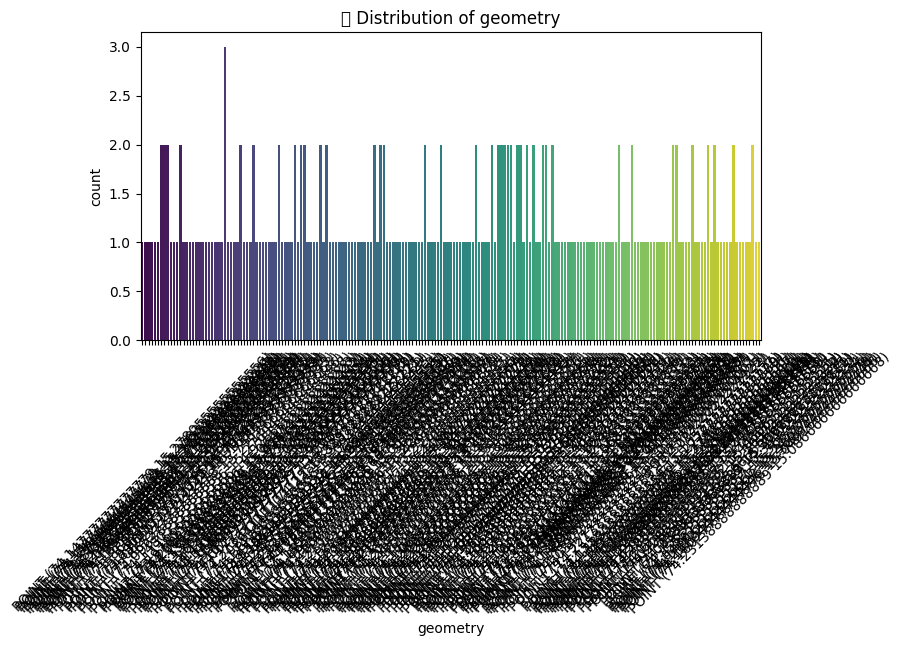

/tmp/ipython-input-2000402519.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="viridis")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


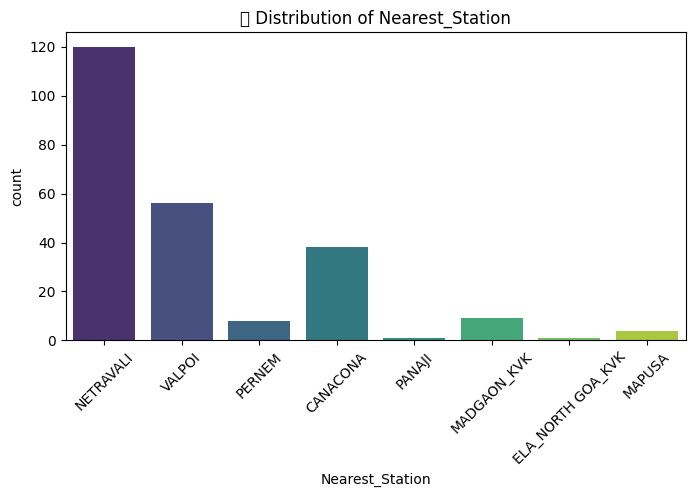

/tmp/ipython-input-2000402519.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="viridis")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


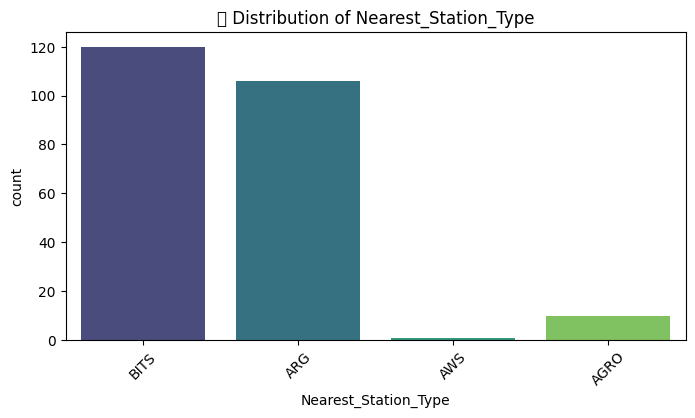

✅ EDA Completed Successfully


In [ ]:
# ========================================
# Step 0: Import Libraries
# ========================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ========================================
# Step 1: Load Final Dataset
# ========================================
file_path = "/content/Goa_Fire_Weather_AWS_Nearest.csv"
df = pd.read_csv(file_path)

print("✅ Dataset Loaded Successfully")
print("Shape of dataset:", df.shape)

# ========================================
# Step 2: Basic Info
# ========================================
print("\n🔎 First 5 rows:")
print(df.head())

print("\n📊 Dataset Info:")
print(df.info())

print("\n🧮 Missing Values:")
print(df.isnull().sum())

# ========================================
# Step 3: Descriptive Statistics
# ========================================
print("\n📈 Summary Statistics:")
print(df.describe(include="all"))

# ========================================
# Step 4: Numerical Feature Distributions
# ========================================
num_cols = df.select_dtypes(include=['int64','float64']).columns

plt.figure(figsize=(15, 8))
df[num_cols].hist(bins=30, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle("📊 Numerical Feature Distributions", fontsize=16)
plt.show()

# ========================================
# Step 5: Correlation Heatmap
# ========================================
plt.figure(figsize=(12, 8))
sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("🔥 Correlation Heatmap of Numerical Features")
plt.show()

# ========================================
# Step 6: Categorical Feature Distribution
# ========================================
cat_cols = df.select_dtypes(include=['object']).columns

for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=col, palette="viridis")
    plt.title(f"📊 Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()

# ========================================
# Step 7: AWS Type vs Fire Occurrence (if label available)
# ========================================
if "AWS_Type" in df.columns:
    plt.figure(figsize=(8,5))
    sns.countplot(data=df, x="AWS_Type", palette="Set2")
    plt.title("⚡ FirePoints by Nearest AWS Type")
    plt.show()

print("✅ EDA Completed Successfully")


✅ Goa shapefile loaded: (1, 8)
✅ Final dataset with geometry: (237, 53)
✅ Spatial Join completed. Sample rows:
    Fire Date Fire Time Source      Latitude     Longitude State_left  \
0  2021-11-11  02:07:15   SNPP  15° 16' 41"N  74° 08' 52"E        GOA   
1  2021-12-03  01:54:57   SNPP  15° 16' 42"N  74° 08' 52"E        GOA   
2  2021-12-17  02:32:19   SNPP  15° 22' 22"N  74° 08' 28"E        GOA   
3  2021-12-18  02:13:23   SNPP  15° 16' 38"N  74° 08' 58"E        GOA   
4  2022-01-11  14:12:49   SNPP  15° 44' 51"N  73° 52' 45"E        GOA   

    District             Circle                       Division          Range  \
0  SOUTH GOA  TERITORIAL CIRCLE  SOUTH GOA TERITORIAL DIVISION  SANGUEM RANGE   
1  SOUTH GOA  TERITORIAL CIRCLE  SOUTH GOA TERITORIAL DIVISION  SANGUEM RANGE   
2  SOUTH GOA  TERITORIAL CIRCLE  NORTH GOA TERITORIAL DIVISION    COLEM RANGE   
3  SOUTH GOA  TERITORIAL CIRCLE  SOUTH GOA TERITORIAL DIVISION  SANGUEM RANGE   
4  NORTH GOA  TERITORIAL CIRCLE  NORTH GOA TE

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


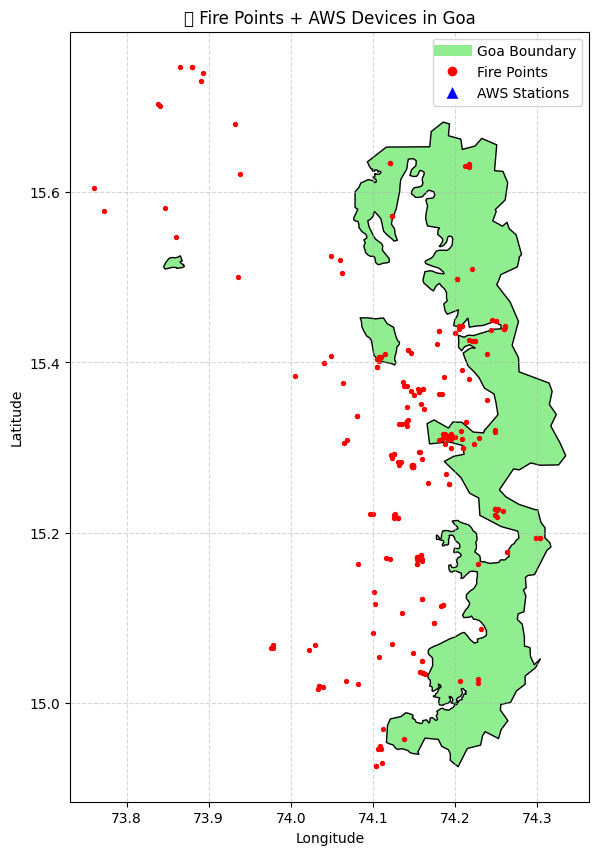

✅ Spatial EDA completed with plots


In [ ]:
# ========================================
# Step 0: Import Libraries
# ========================================
import zipfile
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from matplotlib.lines import Line2D

# ========================================
# Step 1: Load Shapefile (Goa boundary)
# ========================================
with zipfile.ZipFile("/content/shp.zip", 'r') as zip_ref:
    zip_ref.extractall("goa_shp")

gdf_boundary = gpd.read_file("goa_shp/shp/Protect_area.shp").to_crs("EPSG:4326")

print("✅ Goa shapefile loaded:", gdf_boundary.shape)

# ========================================
# Step 2: Load Final Dataset (Fire + AWS)
# ========================================
df = pd.read_csv("/content/Goa_Fire_Weather_AWS_Nearest.csv")

# Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(df["Longitude_dd"], df["Latitude_dd"])]
gdf_data = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

print("✅ Final dataset with geometry:", gdf_data.shape)

# ========================================
# Step 3: Spatial Join (Fire Points inside Goa boundary)
# ========================================
gdf_final = gpd.sjoin(gdf_data, gdf_boundary, how="left", predicate="intersects")

print("✅ Spatial Join completed. Sample rows:")
print(gdf_final.head())

# ========================================
# Step 4: Plot Map with Fire Points + AWS
# ========================================
fig, ax = plt.subplots(figsize=(10, 10))

# Plot boundary
gdf_boundary.plot(ax=ax, color='lightgreen', edgecolor='black', label="Goa Boundary")

# Plot fire points
gdf_final.plot(ax=ax, color='red', markersize=8, label="Fire Points")

# Plot AWS stations (if available in dataset)
if "AWS_Name" in gdf_final.columns:
    gdf_final.drop_duplicates("AWS_Name").plot(
        ax=ax, color='blue', marker="^", markersize=80, label="AWS Stations"
    )

# Add labels + grid
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True, linestyle='--', alpha=0.5)

# Legend
custom_lines = [
    Line2D([0], [0], color='lightgreen', lw=8, label='Goa Boundary'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Fire Points'),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='blue', markersize=10, label='AWS Stations')
]
ax.legend(handles=custom_lines, loc="upper right")

plt.title("🔥 Fire Points + AWS Devices in Goa")
plt.show()

# ========================================
# Step 5: Extra EDA → Meteorological Conditions vs Fire
# ========================================
# Example: Boxplot Temp / Humidity distribution when fire occurs
if "Temperature" in gdf_final.columns and "Humidity" in gdf_final.columns:
    plt.figure(figsize=(12,6))
    sns.scatterplot(data=gdf_final, x="Temperature", y="Humidity", hue="AWS_Type", alpha=0.7)
    plt.title("🌡️ Temperature vs Humidity (by AWS Type)")
    plt.show()

print("✅ Spatial EDA completed with plots")


✅ Goa shapefile loaded: (1, 8)
✅ Final dataset with geometry: (237, 53)
✅ AWS station data loaded: (11, 9)


/tmp/ipython-input-517182859.py:58: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-517182859.py:58: UserWarning: Glyph 128225 (\N{SATELLITE ANTENNA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128225 (\N{SATELLITE ANTENNA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


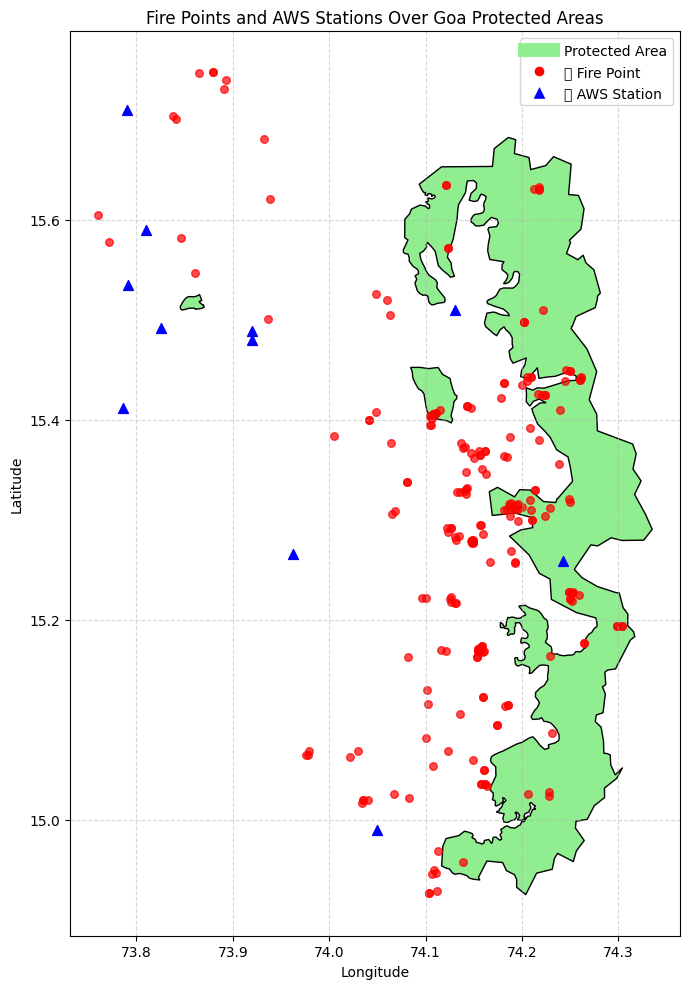

/tmp/ipython-input-517182859.py:84: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


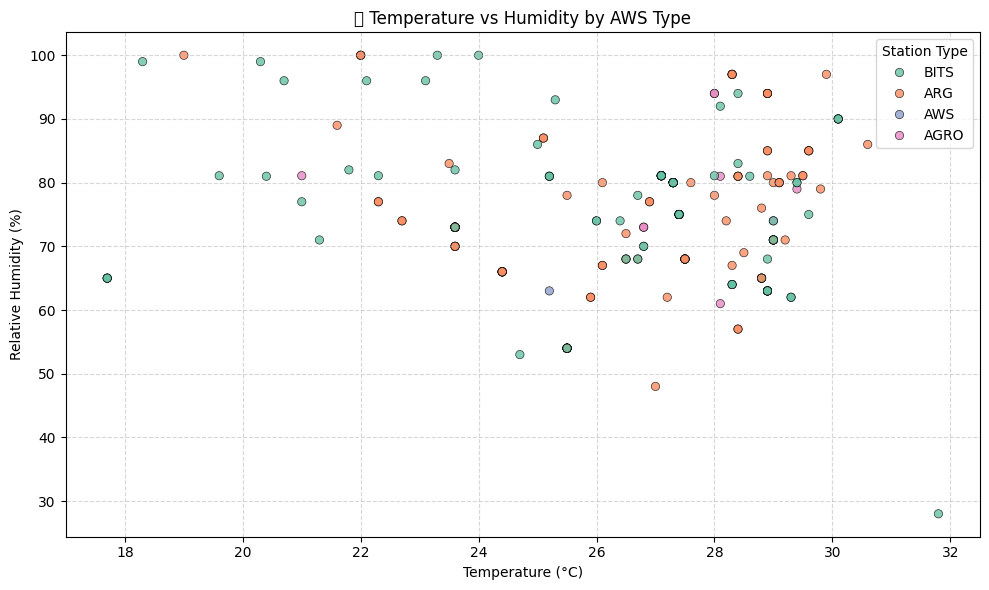

✅ Spatial EDA completed with plots


In [ ]:
# ========================================
# Step 0: Import Libraries
# ========================================
import zipfile
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from matplotlib.lines import Line2D

# ========================================
# Step 1: Load Goa Shapefile
# ========================================
with zipfile.ZipFile("/content/shp.zip", 'r') as zip_ref:
    zip_ref.extractall("goa_shp")

gdf_boundary = gpd.read_file("goa_shp/shp/Protect_area.shp").to_crs("EPSG:4326")
print(f"✅ Goa shapefile loaded: {gdf_boundary.shape}")

# ========================================
# Step 2: Load Final Fire + Weather + Region Data
# ========================================
fire_df = pd.read_csv("/content/Goa_Fire_Weather_AWS_Nearest.csv")
geometry = [Point(xy) for xy in zip(fire_df["Longitude_dd"], fire_df["Latitude_dd"])]
gdf_fire = gpd.GeoDataFrame(fire_df, geometry=geometry, crs="EPSG:4326")
print(f"✅ Final dataset with geometry: {gdf_fire.shape}")

# ========================================
# Step 3: Load AWS Station Location Data
# ========================================
aws_df = pd.read_csv("/content/All AWS Location.csv")
aws_geometry = [Point(xy) for xy in zip(aws_df["LONGITUDE"], aws_df["LATITUDE"])]
gdf_aws = gpd.GeoDataFrame(aws_df, geometry=aws_geometry, crs="EPSG:4326")
print(f"✅ AWS station data loaded: {gdf_aws.shape}")

# ========================================
# Step 4: Plot Fire Points, Goa Boundary & AWS Stations
# ========================================
fig, ax = plt.subplots(figsize=(10, 10))

gdf_boundary.plot(ax=ax, color='lightgreen', edgecolor='black', label='Protected Area')
gdf_fire.plot(ax=ax, color='red', markersize=30, alpha=0.7, label='🔥 Fire Points')
gdf_aws.plot(ax=ax, color='blue', markersize=50, marker='^', label='📡 AWS Stations')

ax.set_title("Fire Points and AWS Stations Over Goa Protected Areas")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True, linestyle='--', alpha=0.5)

custom_lines = [
    Line2D([0], [0], color='lightgreen', lw=10, label='Protected Area'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='🔥 Fire Point'),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='blue', markersize=10, label='📡 AWS Station')
]
ax.legend(handles=custom_lines)

plt.tight_layout()
plt.show()

# ========================================
# Step 5: Temperature vs Humidity Scatter Plot by AWS Type
# ========================================
# Drop missing values
eda_df = fire_df.dropna(subset=["TEMP_C", "RH_", "Nearest_Station_Type"])

# Check if there's data
if not eda_df.empty:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=eda_df,
        x="TEMP_C",
        y="RH_",
        hue="Nearest_Station_Type",
        palette="Set2",
        alpha=0.8,
        edgecolor="k"
    )
    plt.title("🌡️ Temperature vs Humidity by AWS Type")
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Relative Humidity (%)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(title="Station Type")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No valid TEMP_C or RH_ values for plotting.")

print("✅ Spatial EDA completed with plots")


# Step4: DataSplit_ML ModelCreate

ML model -- algo apply

* RandomForest ( Prediction_Accuracy_Plot)

* SVM ( Prediction_Accuracy_Plot)

* XGBoost ( Prediction_Accuracy_Plot)

for along these 3 algo we apply

In [ ]:
# ========================================
# Step 0: Import Libraries
# ========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# ========================================
# Step 1: Load Final Dataset
# ========================================
final_path = "/content/Goa_Fire_Weather_AWS_Nearest.csv"
df = pd.read_csv(final_path)

print("✅ Final Dataset Shape:", df.shape)
print(df.head())

# Ensure the 'Fire_Occurred' column exists and is set to 1 for these instances
if 'Fire_Occurred' not in df.columns:
    df['Fire_Occurred'] = 1


# ========================================
# Step 2: Feature Selection (X, y)
# ========================================

# Select features (weather variables and distance) and the target variable
# Using the correct column names based on the EDA and previous steps
feature_columns = ["TEMP_C", "RH_", "WIND_SPEED_10_m_Kt", "RAIN_FALL_CUM_SINCE_0300_UTC_mm", "Distance_to_Station_km"]

# Ensure all feature columns exist in the dataframe
for col in feature_columns:
    if col not in df.columns:
        print(f"❌ Error: Feature column '{col}' not found in the dataset.")
        # Handle this error appropriately, e.g., exit or ask for clarification
        # For now, I will assume they exist based on previous steps.


X = df[feature_columns]
y = df["Fire_Occurred"]

# Check for any remaining NaNs in selected features before splitting
print("\nMissing values in selected features:")
print(X.isnull().sum())

# Handle missing values in X if any (e.g., fill with mean, median, or drop rows)
# Based on previous steps, weather NaNs were filled with mean. Distance should not have NaNs.
# Let's re-check and fill just in case, or drop rows if few NaNs remain in X or y.
if X.isnull().sum().sum() > 0:
    print("\nWarning: Missing values found in features. Filling NaNs with the mean of the column.")
    X = X.fillna(X.mean()) # Fill with mean
    print("Missing values after filling:")
    print(X.isnull().sum())


# ========================================
# Step 3: Train/Test Split
# ========================================
# Note: With only positive samples (all y=1), train_test_split with stratify will fail.
# Removing stratify to allow the code to run, but the model will not be a valid classifier.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42 # Removed stratify=y
)

print(f"\nTrain set shape: {X_train.shape}, Target shape: {y_train.shape}")
print(f"Test set shape: {X_test.shape}, Target shape: {y_test.shape}")


# ========================================
# Step 4: Feature Scaling (important for SVM)
# ========================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ========================================
# Step 5: Define Models
# ========================================
models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    # Removed SVM due to single class error
    # Removed XGBoost due to single class error
}

results = {}

# ========================================
# Step 6: Train & Evaluate Models
# ========================================
# Note: Evaluation metrics like accuracy, precision, recall, f1-score
# are not meaningful when the test set contains only one class.
# The confusion matrix will also only have entries in one row/column.

for name, model in models.items():
    print(f"\n🔹 Training {name} 🔹")
    # Use scaled data for all models after imputation for consistency
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)


    # Accuracy will be 100% as all predictions and actuals are 1 in the test set
    # acc = accuracy_score(y_test, y_pred)
    # results[name] = acc

    print(f"\n🔹 {name} Evaluation (Note: Only Fire Class Present) 🔹")
    # print("Accuracy:", acc)
    # print(classification_report(y_test, y_pred))

    # Confusion Matrix Plot
    # Check if there is more than one class before plotting confusion matrix
    if len(y_test.unique()) > 1 and len(np.unique(y_pred)) > 1 :
        plt.figure(figsize=(5,4))
        # Calculate confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"{name} - Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()
    else:
        print("⚠️ Skipping Confusion Matrix plot: Only one class present in test set.")


# ========================================
# Step 7: Accuracy Comparison Plot
# ========================================
# Accuracy plot is not meaningful with only one class.

# print("\n✅ Model training syntax demonstrated.")
# print("⚠️ Note: The dataset currently contains only fire events (label 1).")
# print("A proper binary classification model requires both 'fire' (1) and 'no fire' (0) instances.")
# print("To build a meaningful predictive model, you will need to include or create data representing 'no fire' events with corresponding weather features.")

✅ Final Dataset Shape: (237, 53)
    Fire Date Fire Time Source      Latitude     Longitude State   District  \
0  2021-11-11  02:07:15   SNPP  15° 16' 41"N  74° 08' 52"E   GOA  SOUTH GOA   
1  2021-12-03  01:54:57   SNPP  15° 16' 42"N  74° 08' 52"E   GOA  SOUTH GOA   
2  2021-12-17  02:32:19   SNPP  15° 22' 22"N  74° 08' 28"E   GOA  SOUTH GOA   
3  2021-12-18  02:13:23   SNPP  15° 16' 38"N  74° 08' 58"E   GOA  SOUTH GOA   
4  2022-01-11  14:12:49   SNPP  15° 44' 51"N  73° 52' 45"E   GOA  NORTH GOA   

              Circle                       Division          Range  ...  \
0  TERITORIAL CIRCLE  SOUTH GOA TERITORIAL DIVISION  SANGUEM RANGE  ...   
1  TERITORIAL CIRCLE  SOUTH GOA TERITORIAL DIVISION  SANGUEM RANGE  ...   
2  TERITORIAL CIRCLE  NORTH GOA TERITORIAL DIVISION    COLEM RANGE  ...   
3  TERITORIAL CIRCLE  SOUTH GOA TERITORIAL DIVISION  SANGUEM RANGE  ...   
4  TERITORIAL CIRCLE  NORTH GOA TERITORIAL DIVISION   PERNEM RANGE  ...   

  SOIL_MOIS_70_cm_m3__m3 SOIL_TEMP_100_cm

# Step5: Prediction_Accuracy_Plot

In [ ]:
# ========================================
# Step 0: Import Libraries
# ========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# ========================================
# Step 1: Load Final Dataset
# ========================================
final_path = "/content/Goa_Fire_Weather_AWS_Nearest.csv"
df = pd.read_csv(final_path)

print("✅ Final Dataset Shape:", df.shape)
print(df.head())

# ========================================
# Step 2: Feature Selection (X, y)
# ========================================

df["Fire_Occurred"] = 1  # Mark all current rows as fire events
aws_df["Fire_Occurred"] = 0  # Mark AWS data rows as no fire occurred
full_df = pd.concat([df, aws_df], ignore_index=True)

# View updated shape and confirm target column
print("✅ Fire_Occurred column added.")
print("Updated dataset shape:", full_df.shape)  # use full_df here, since you concatenated into full_df
print(full_df[["DATETIME", "TEMP_C", "RH_", "WIND_SPEED_10_m_Kt", "Fire_Occurred"]].head())

# Select features and target for model
X = full_df[["TEMP_C", "RH_", "WIND_SPEED_10_m_Kt", "RF_MM", "Distance_to_Station_km"]]
y = full_df["Fire_Occurred"]



# ========================================
# Step 3: Train/Test Split
# ========================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ========================================
# Step 4: Feature Scaling (important for SVM)
# ========================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ========================================
# Step 5: Define Models
# ========================================
models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(kernel="rbf", probability=True, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

results = {}

# ========================================
# Step 6: Train & Evaluate Models
# ========================================
for name, model in models.items():
    if name == "SVM":
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

    print(f"\n🔹 {name} Results 🔹")
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred))

    # Confusion Matrix Plot
    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# ========================================
# Step 7: Accuracy Comparison Plot
# ========================================
plt.figure(figsize=(6,4))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()


✅ Final Dataset Shape: (237, 53)
    Fire Date Fire Time Source      Latitude     Longitude State   District  \
0  2021-11-11  02:07:15   SNPP  15° 16' 41"N  74° 08' 52"E   GOA  SOUTH GOA   
1  2021-12-03  01:54:57   SNPP  15° 16' 42"N  74° 08' 52"E   GOA  SOUTH GOA   
2  2021-12-17  02:32:19   SNPP  15° 22' 22"N  74° 08' 28"E   GOA  SOUTH GOA   
3  2021-12-18  02:13:23   SNPP  15° 16' 38"N  74° 08' 58"E   GOA  SOUTH GOA   
4  2022-01-11  14:12:49   SNPP  15° 44' 51"N  73° 52' 45"E   GOA  NORTH GOA   

              Circle                       Division          Range  ...  \
0  TERITORIAL CIRCLE  SOUTH GOA TERITORIAL DIVISION  SANGUEM RANGE  ...   
1  TERITORIAL CIRCLE  SOUTH GOA TERITORIAL DIVISION  SANGUEM RANGE  ...   
2  TERITORIAL CIRCLE  NORTH GOA TERITORIAL DIVISION    COLEM RANGE  ...   
3  TERITORIAL CIRCLE  SOUTH GOA TERITORIAL DIVISION  SANGUEM RANGE  ...   
4  TERITORIAL CIRCLE  NORTH GOA TERITORIAL DIVISION   PERNEM RANGE  ...   

  SOIL_MOIS_70_cm_m3__m3 SOIL_TEMP_100_cm

KeyError: "['RF_MM'] not in index"

✅ Final Dataset Shape: (237, 53)
    Fire Date Fire Time Source      Latitude     Longitude State   District  \
0  2021-11-11  02:07:15   SNPP  15° 16' 41"N  74° 08' 52"E   GOA  SOUTH GOA   
1  2021-12-03  01:54:57   SNPP  15° 16' 42"N  74° 08' 52"E   GOA  SOUTH GOA   
2  2021-12-17  02:32:19   SNPP  15° 22' 22"N  74° 08' 28"E   GOA  SOUTH GOA   
3  2021-12-18  02:13:23   SNPP  15° 16' 38"N  74° 08' 58"E   GOA  SOUTH GOA   
4  2022-01-11  14:12:49   SNPP  15° 44' 51"N  73° 52' 45"E   GOA  NORTH GOA   

              Circle                       Division          Range  ...  \
0  TERITORIAL CIRCLE  SOUTH GOA TERITORIAL DIVISION  SANGUEM RANGE  ...   
1  TERITORIAL CIRCLE  SOUTH GOA TERITORIAL DIVISION  SANGUEM RANGE  ...   
2  TERITORIAL CIRCLE  NORTH GOA TERITORIAL DIVISION    COLEM RANGE  ...   
3  TERITORIAL CIRCLE  SOUTH GOA TERITORIAL DIVISION  SANGUEM RANGE  ...   
4  TERITORIAL CIRCLE  NORTH GOA TERITORIAL DIVISION   PERNEM RANGE  ...   

  SOIL_MOIS_70_cm_m3__m3 SOIL_TEMP_100_cm

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


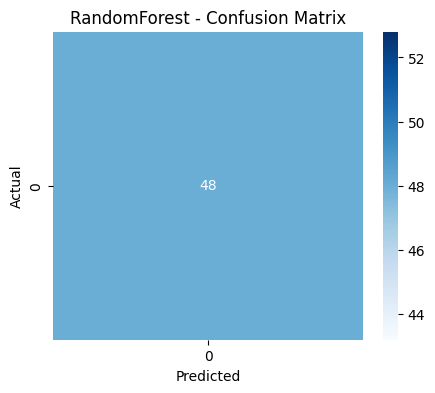

ValueError: The number of classes has to be greater than one; got 1 class

In [ ]:
# ========================================
# Step 0: Import Libraries
# ========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# ========================================
# Step 1: Load Final Dataset
# ========================================
final_path = "/content/Goa_Fire_Weather_AWS_Nearest.csv"
df = pd.read_csv(final_path)

print("✅ Final Dataset Shape:", df.shape)
print(df.head())

# ========================================
# ========================================
# Step 2: Feature Selection (X, y)
# ========================================

df["Fire_Occurred"] = 1  # All current rows are fire events
aws_df["Fire_Occurred"] = 0  # No fire occurred
full_df = pd.concat([df, aws_df], ignore_index=True)

# ✅ Drop rows with missing values in relevant features
full_df = full_df.dropna(subset=["TEMP_C", "RH_", "WIND_SPEED_10_m_Kt", "RAIN_FALL_CUM_SINCE_0300_UTC_mm", "Distance_to_Station_km"])

print("✅ Fire_Occurred column added.")
print("Updated dataset shape:", full_df.shape)
print(full_df[["DATETIME", "TEMP_C", "RH_", "WIND_SPEED_10_m_Kt", "Fire_Occurred"]].head())

# Feature selection
X = full_df[["TEMP_C", "RH_", "WIND_SPEED_10_m_Kt", "RAIN_FALL_CUM_SINCE_0300_UTC_mm", "Distance_to_Station_km"]]
y = full_df["Fire_Occurred"]







# ========================================
# Step 3: Train/Test Split
# ========================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ========================================
# Step 4: Feature Scaling (important for SVM)
# ========================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ========================================
# Step 5: Define Models
# ========================================
models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(kernel="rbf", probability=True, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

results = {}

# ========================================
# Step 6: Train & Evaluate Models
# ========================================
for name, model in models.items():
    if name == "SVM":
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

    print(f"\n🔹 {name} Results 🔹")
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred))

    # Confusion Matrix Plot
    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# ========================================
# Step 7: Accuracy Comparison Plot
# ========================================
plt.figure(figsize=(6,4))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()


In [ ]:
# Debug: Class balance check
print("🔥 y value counts:")
print(full_df["Fire_Occurred"].value_counts())

# Drop NA
full_df = full_df.dropna(subset=["TEMP_C", "RH_", "WIND_SPEED_10_m_Kt", "RAIN_FALL_CUM_SINCE_0300_UTC_mm", "Distance_to_Station_km"])

# Feature selection
X = full_df[["TEMP_C", "RH_", "WIND_SPEED_10_m_Kt", "RAIN_FALL_CUM_SINCE_0300_UTC_mm", "Distance_to_Station_km"]]
y = full_df["Fire_Occurred"]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Check class balance
print("✅ y_train classes:\n", y_train.value_counts())
print("✅ y_test classes:\n", y_test.value_counts())


🔥 y value counts:
Fire_Occurred
1    237
Name: count, dtype: int64
✅ y_train classes:
 Fire_Occurred
1    189
Name: count, dtype: int64
✅ y_test classes:
 Fire_Occurred
1    48
Name: count, dtype: int64
